# Whiteshark Spectral

In this notebook we analyze the simulations in spectral space.


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
#import cv2
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

#from mpl_toolkits.basemap import Basemap
import os
import sys
#import 
from netCDF4 import Dataset
import scipy.integrate as integrate 

sys.path.append('/home/jacob13/PYROMSEDIT/')

sys.path.append("/home/jacob13/pyspec-master/") 
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm

######################
#some ROMS tools examples 
######################

sys.path.append("/home/jacob13/CROCO-NH/Modules/") 
import R_tools as tools
import R_tools_fort as toolsF

###################################################################################
# Use fortran order for arrays
####################################################################################

def Forder(var):
   return np.asfortranarray(var.T,dtype=np.float64)

####################################################################################


#from grid_MOD import get_ROMS_grid_MOD
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


In [10]:
# Load MSHARK grid file
file = '/data/thomas/jacob13/WHITESHARKCAFE/MSHARK/mshark_grd.nc'
msharkgrid = xr.open_dataset(file)

# Load files (concatenate across all files)
filelocation = '/data/thomas/jacob13/WHITESHARKCAFE/MSHARK/'
dsmshark= xr.open_mfdataset(filelocation+'mshark_his*.nc', concat_dim='time', data_vars='minimal', compat='equals')
#dsmshark = xr.open_dataset(filelocation+'mshark_his.0000.nc')
msharkyearday = np.mod(dsmshark.scrum_time/86400, 360)

# Calculate z level
hc = dsmshark.hc
Cs_r = Forder(dsmshark.Cs_r)
Cs_w = Forder(dsmshark.Cs_w)

topo = Forder(msharkgrid.h.values)
zeta = Forder(dsmshark.zeta.values[0,:,:])

(z_r,z_w) = toolsF.zlevs(topo, zeta[:,:], hc, Cs_r, Cs_w)



/usr/local/anaconda3/envs/lagranto/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/usr/local/anaconda3/envs/lagranto/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [13]:
msharkyearday.values[-1]

239.0

In [ ]:
# Load WHITESHARK grid file
# Note I'm assigning this to mshark so I don't have to change the below analysis code.
file = '/data/thomas/jacob13/WHITESHARKCAFE/WHITESHARK/whiteshark_grd.nc'
msharkgrid = xr.open_dataset(file)

# Load files (concatenate across all files)
filelocation = '/data/thomas/jacob13/WHITESHARKCAFE/WHITESHARK/'
dsmshark= xr.open_mfdataset(filelocation+'whiteshark_his*.nc', concat_dim='time')#, data_vars='minimal', compat='equals')
#dschesa= xr.open_dataset(filelocation+'chesa2_his.0096.nc')
msharkyearday = np.mod(dsmshark.scrum_time/86400, 360)
# Calculate z level
hc = dsmshark.hc
Cs_r = Forder(dsmshark.Cs_r)
Cs_w = Forder(dsmshark.Cs_w)

topo = Forder(msharkgrid.h.values)
zeta = Forder(dsmshark.zeta.values[0,:,:])

(z_r,z_w) = toolsF.zlevs(topo, zeta[:,:], hc, Cs_r, Cs_w)



In [ ]:
# Quick and dirty test
ts = 200
dx = np.mean(msharkgrid.pm**(-1)).values
dy = np.mean(msharkgrid.pn**(-1)).values

uvar = tools.u2rho_2d(Forder(dsmshark.u[ts,-1,:,:].values))

spec2d_u = spec.TWODimensional_spec(uvar,dx,dy)
#spec2d_v = spec.TWODimensional_spec(tools.v2rho_3d(Forder(dsmshark.v[ts,-1,:,:])),dx,dy)

plt.loglog(spec2d_u.ki,spec2d_u.ispec) #DJF


In [ ]:
# Quick and dirty test of co-spectrum
ts = 200
dx = np.mean(msharkgrid.pm**(-1)).values
dy = np.mean(msharkgrid.pn**(-1)).values

wvar = tools.w2rho(Forder(dsmshark.w[ts,:,:,:].values))
bvar = -9.8*tools.rho_eos(Forder(dsmshark.temp[ts,:,:,:].values), Forder(dsmshark.salt[ts,:,:,:].values), z_r, z_w, 1024)/1024

cospec2d = spec.CO_TWODimensional_spec(wvar[:,:,-1], bvar[:,:,-1],dx,dy)
#spec2d_v = spec.TWODimensional_spec(tools.v2rho_3d(Forder(dsmshark.v[ts,-1,:,:])),dx,dy)

#plt.loglog(spec2d_u.ki,spec2d_u.ispec) #DJF


In [ ]:
plt.loglog(cospec2d.ki,cospec2d.ispec) #DJF


In [14]:
# Calculate spectra by month
ts = range(245,250)
dx = np.mean(msharkgrid.pm**(-1)).values
dy = np.mean(msharkgrid.pn**(-1)).values

months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
counter = 0
esm = np.zeros((12,319))
#esm = np.zeros((12,213))

for mnth in months:
    inds = np.where((msharkyearday > (mnth-1)*30) & (msharkyearday <= mnth*30))[0]
    print(inds)
    counter = 0
    for ti in inds:
        uvar = tools.u2rho_2d(Forder(dsmshark.u[ti,-1,:,:].values))
        vvar = tools.v2rho_2d(Forder(dsmshark.v[ti,-1,:,:].values))
        spec2d_u = spec.TWODimensional_spec(uvar,dx,dy);
        spec2d_v = spec.TWODimensional_spec(vvar,dx,dy);
        if counter == 0:
            es = 0.5*(spec2d_u.ispec + spec2d_v.ispec)
        else:
            es += 0.5*(spec2d_u.ispec + spec2d_v.ispec)
        counter += 1
    esm[mnth-1,:] = es/(counter)

[121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
[151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
[ 91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(

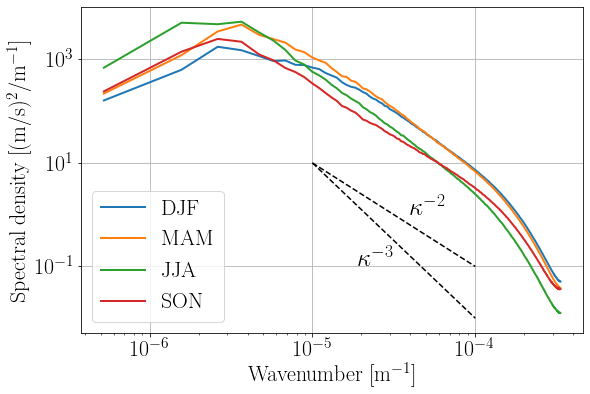

In [17]:
# Plot Spectra by Month
k3 = np.array([1e-5,1e-4])
E3 = 1/k3**3/1e14
E2 = 1/k3**2; E2 = E2/E2[0]*E3[0]


fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(111)

plt.loglog(spec2d_u.ki,np.mean(esm[[11,0, 1],:], axis=0), label='DJF', linewidth=2) #DJF
plt.loglog(spec2d_u.ki,np.mean(esm[[2, 3, 4],:], axis=0), label='MAM', linewidth=2) #MAM
plt.loglog(spec2d_u.ki,np.mean(esm[[5, 6, 7],:], axis=0), label='JJA', linewidth=2) #DJF
plt.loglog(spec2d_u.ki,np.mean(esm[[8, 9, 10],:], axis=0), label='SON', linewidth=2) #DJF

plt.loglog(k3,E3,'k--')
plt.loglog(k3,E2,'k--')
plt.text(4.e-5,1e-0,r'$\kappa^{-2}$',fontsize=25)
plt.text(1.9e-5,1.05e-1,r'$\kappa^{-3}$',fontsize=25)

plt.grid()
plt.legend()
ax.set_xlabel(r"Wavenumber [m$^{-1}$]")
ax.set_ylabel(r"Spectral density [(m/s)$^2$/m$^{-1}$]")
plt.savefig('MonthlySurfaceEKE_1p5km.pdf', bbox_inches='tight')

In [18]:
# Calculate co-spectra over range of depths by month
# Assume constant z level (ie along sigma levels)



dx = np.mean(msharkgrid.pm**(-1)).values
dy = np.mean(msharkgrid.pn**(-1)).values

indd = np.argmin(np.abs(np.nanmean(z_r, axis=(0,1))+300))
zlength = 80 - indd
months = [4]
counter = 0
#esm = np.zeros((12,319))
csm = np.zeros((1,zlength, 319))


for mnth in months:
    inds = np.where((msharkyearday > (mnth-1)*30) & (msharkyearday <= mnth*30))[0]
    print(inds)
    counter = 0
    for ti in inds[0:]:
        # calc wvar and bvar here
        wvar = tools.w2rho(Forder(dsmshark.w[ti,:,:,:].values))
        bvar = -9.8*tools.rho_eos(Forder(dsmshark.temp[ti,:,:,:].values), Forder(dsmshark.salt[ti,:,:,:].values), z_r, z_w, 1024)/1024
        for zi in range(0,zlength):
            print('Z level: ' + str(zi))
            cospec2d = spec.CO_TWODimensional_spec(wvar[:,:,zi+indd], bvar[:,:,zi+indd],dx,dy)
            csm[0,zi,:] += cospec2d.ispec
        counter += 1
    csm[0,:,:] = csm[0,:,:]/counter


[211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240]
[M,L,N] [902, 902, 81]
Z level: 0
(902, 902)
Z level: 1
(902, 902)
Z level: 2
(902, 902)
Z level: 3
(902, 902)
Z level: 4
(902, 902)
Z level: 5
(902, 902)
Z level: 6
(902, 902)
Z level: 7
(902, 902)
Z level: 8
(902, 902)
Z level: 9
(902, 902)
Z level: 10
(902, 902)
Z level: 11
(902, 902)
Z level: 12
(902, 902)
Z level: 13
(902, 902)
Z level: 14
(902, 902)
Z level: 15
(902, 902)
Z level: 16
(902, 902)
Z level: 17
(902, 902)
Z level: 18
(902, 902)
Z level: 19
(902, 902)
Z level: 20
(902, 902)
Z level: 21
(902, 902)
Z level: 22
(902, 902)
Z level: 23
(902, 902)
Z level: 24
(902, 902)
Z level: 25
(902, 902)
Z level: 26
(902, 902)
Z level: 27
(902, 902)
Z level: 28
(902, 902)
Z level: 29
(902, 902)
Z level: 30
(902, 902)
Z level: 31
(902, 902)
Z level: 32
(902, 902)
Z level: 33
(902, 902)
[M,L,N] [902, 902, 81]
Z level: 0
(902, 902)
Z level: 1
(902, 902)
Z level: 2
(902

KeyboardInterrupt: 

In [ ]:
indd

In [ ]:
# Choose cutoff
koff = np.argmin(np.abs(cospec2d.ki - 1/1e5))
# Integrate under cutoff
ci = integrate.trapz(csm[0,:,koff:], x=cospec2d.ki[koff:])
# Plot as function of depth
plt.figure(figsize=(5,6))
plt.plot(ci, np.mean(z_r, axis=(0,1))[indd:], linewidth=2)
plt.ylabel('z (m)')
plt.grid()
plt.xlabel(r'$\langle \hat{w}\hat{b}^* \rangle$ (m$^{2}$ s$^{-3}$)')
#plt.savefig('Cospectra_depth.pdf')

In [ ]:
# CALCULATE TIME SERIES OF WB and EKE

# Choose cutoff
koff = np.argmin(np.abs(cospec2d.ki - 1/1e5))

ci = integrate.trapz(csm[0,:,koff:], x=cospec2d.ki[koff:])
zm = np.argmin(np.abs(ci - np.max(ci))) + indd
np.mean(z_r, axis=(0,1))[zm]


#koff = 0
nt = dsmshark.time.values.shape[0]
nt = 360
toff = 64
# Calculate wb cospectra at choosen depth
csmtime = np.zeros((nt, 319))
ekespec = np.zeros((nt, 319))
csmseries = np.zeros((nt,))
ekeseries = np.zeros((nt,))
ekedir = np.zeros((nt,))
for ti in range(0, nt, 1):
        print(f'Time step {ti} of {nt}')
        # calc wvar and bvar here
        wvar = tools.w2rho(Forder(dsmshark.w[ti+toff,zm-2:zm+2,:,:].values))
        bvar = -9.8*tools.rho_eos(Forder(dsmshark.temp[ti+toff,zm:zm+1,:,:].values), Forder(dsmshark.salt[ti+toff,zm:zm+1,:,:].values), z_r[:,:,zm:zm+1], z_w[:,:,zm-1:zm+1], 1024)/1024
        cospec2d = spec.CO_TWODimensional_spec(wvar[:,:,1], bvar[:,:,0],dx,dy, detrend=True)
        csmtime[ti,:] = cospec2d.ispec
        # EKE
        uvar = tools.u2rho_2d(Forder(dsmshark.u[ti+toff,-1,:,:].values))
        vvar = tools.v2rho_2d(Forder(dsmshark.v[ti+toff,-1,:,:].values))
        spec2d_u = spec.TWODimensional_spec(uvar,dx,dy);
        spec2d_v = spec.TWODimensional_spec(vvar,dx,dy);
        ekespec[ti,:] = 0.5*(spec2d_u.ispec + spec2d_v.ispec)
        ekedir[ti] = 0.5*np.mean((uvar)**2 + (vvar)**2)
        
csmseries = integrate.trapz(csmtime[:,koff:], x=cospec2d.ki[koff:], axis=-1)
ekeseries = integrate.trapz(ekespec[:,koff:], x=spec2d_u.ki[koff:], axis=-1)

xs, csmsorted = zip(*sorted(zip(msharkyearday[toff:],csmseries)))
xs, ekesorted = zip(*sorted(zip(msharkyearday[toff:], ekeseries)))
xs, ekedirsorted = zip(*sorted(zip(msharkyearday[toff:], ekedir)))

In [ ]:
csmsorted[:].shape

In [ ]:
#fig, ax = plt.subplots(2, 1, figsize=(10,3), width_ratios=[3, 1])
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2,2, figure=fig, width_ratios=[3,1])
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[0:,1])

#xs, ys = zip(*sorted(zip(msharkyearday[toff:],ekeseries)))
ax0.plot(xs, ekesorted, linewidth=2)
#xs, ys = zip(*sorted(zip(msharkyearday[toff:],ekedir)))
#ax0.plot(xs, ys, linewidth=2,  linestyle='--')
ax0.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360])
ax0.set_xticklabels([])
ax0.set_xlim(0, 360)
ax0.set_ylim(0, 0.0125)
ax0.grid()
ax0.set_ylabel('$EKE$ (m$^{2}$ s$^{-2}$)')

#W'B' PLOT
#xs, ys = zip(*sorted(zip(msharkyearday[toff:],csmseries)))
ax1.plot(xs, np.array(csmsorted), linewidth=2)
ax1.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360])
ax1.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D' , 'J'])
ax1.set_xlim(0, 360)
#ax1.set_ylim(0, 1.25e-7)
ax1.set_xlabel('Month', labelpad=25)
ax1.grid()
ax1.set_ylabel('$\langle w\' b\' \\rangle$ (m$^{2}$ s$^{-3}$)', labelpad=25)
#plt.savefig('BFlux_annual.pdf')

ci = integrate.trapz(csm[0,:,koff:], x=cospec2d.ki[koff:])
# Plot as function of depth
ax2.plot(ci, np.mean(z_r, axis=(0,1))[indd:], linewidth=2)
ax2.set_ylabel('z (m)')
ax2.grid()
ax2.axhline(np.mean(z_r, axis=(0,1))[zm], linestyle='--', color='k')
ax2.set_ylim(-200, 0)
ax2.set_xticks([0, 2.5e-8, 5e-8, 7.5e-8])
ax2.set_xlim(-1e-8, 9e-8)

ax2.set_xlabel('$\langle w\' b\' \\rangle$ (m$^{2}$ s$^{-3}$)', labelpad=25)
plt.subplots_adjust(wspace=0.3, hspace = 0.2)
#plt.savefig('CombinedBFlux.pdf', bbox_inches='tight')

In [20]:
# CALCULATE TIME SERIES OF WB and EKE OVER UPPER 100 M

# Choose cutoff
koff = np.argmin(np.abs(cospec2d.ki - 1/1e5))
#koff = 1
ci = integrate.trapz(csm[0,:,koff:], x=cospec2d.ki[koff:])
zm = 64 #-100 m depth
zm = 58 #-150 m depth
#koff = 0
nt = dsmshark.time.values.shape[0]
nt = 360
toff = 0
# Calculate wb cospectra at choosen depth
wpbp = np.zeros((nt,80-zm))
ekez = np.zeros((nt,80-zm))
eked = np.zeros((nt,80-zm))
for ti in range(0, 360, 1):
    print(f'Time step {ti} of {nt}')
    wvar = tools.w2rho(Forder(dsmshark.w[ti+toff,:,:,:].values))
    bvar = -9.8/1024*(1024+tools.rho_eos(Forder(dsmshark.temp[ti+toff,:,:,:].values), Forder(dsmshark.salt[ti+toff,:,:,:].values),z_r, z_w, 1024))
    for j in range(zm,80):
        # calc wvar and bvar here
        #wvar = tools.w2rho(Forder(dsmshark.w[ti+toff,j-2:j+1,:,:].values))
        #bvar = -9.8*(1024+tools.rho_eos(Forder(dsmshark.temp[ti+toff,j,:,:].values), Forder(dsmshark.salt[ti+toff,j,:,:].values), z_r[:,:,j], z_w[:,:,j-1:j+1], 1024))/1024
        cospec2d = spec.CO_TWODimensional_spec(bvar[:,:,j],wvar[:,:,j],dx,dy, detrend=True)
        wpbp[ti,j-zm] = integrate.trapz(cospec2d.ispec[koff:], x=cospec2d.ki[koff:], axis=-1)
        # EKE
        uvar = tools.u2rho_2d(Forder(dsmshark.u[ti+toff,j,:,:].values))
        vvar = tools.v2rho_2d(Forder(dsmshark.v[ti+toff,j,:,:].values))
        spec2d_u = spec.TWODimensional_spec(uvar,dx,dy, detrend=True);
        spec2d_v = spec.TWODimensional_spec(vvar,dx,dy, detrend=True);
        #spec2d_w = spec.TWODimensional_spec(wvar[:,:,1], dx, dy)
        ekez[ti,j-zm] = integrate.trapz(0.5*(spec2d_u.ispec[koff:] + spec2d_v.ispec[koff:]), x=spec2d_u.ki[koff:])
        eked[ti,j-zm] = np.mean(0.5*(uvar**2 + vvar**2))
        
ekezi= integrate.trapz(ekez, x=np.mean(z_r[:,:,zm:], axis=(0,1)), axis=-1)
ekedi = integrate.trapz(eked, x=np.mean(z_r[:,:,zm:], axis=(0,1)), axis=-1)
wpbpti= integrate.cumtrapz(integrate.trapz(wpbp, x=np.mean(z_r[:,:,zm:], axis=(0,1)), axis=-1), x=msharkyearday[toff:]*86400, initial=0)


Time step 0 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 1 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(90

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 11 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)


(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 22 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)


(902, 902)
Time step 32 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 33 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 43 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)


(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 54 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)


(902, 902)
(902, 902)
(902, 902)
Time step 64 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 65 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 75 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)


(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 86 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)


(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 96 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 97 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 107 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 118 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 128 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 129 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 139 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 150 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 160 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 161 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 171 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 182 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 192 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 193 of 360


(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 203 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 214 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 224 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 235 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
Time step 245 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 246 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 256 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 267 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 277 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 278 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 288 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 299 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 309 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 310 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 320 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 331 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 341 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 342 of 360
[M,L,N] [90

(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
Time step 352 of 360
[M,L,N] [902, 902, 81]
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)
(902, 902)

In [131]:
zm=58

In [22]:
ekezi= integrate.trapz(ekez, x=np.mean(z_r[:,:,zm:], axis=(0,1)), axis=-1)/np.abs(np.mean(z_r, axis=(0,1))[zm])
wpbpi= integrate.trapz(wpbp, x=np.mean(z_r[:,:,zm:], axis=(0,1)), axis=-1)/np.abs(np.mean(z_r, axis=(0,1))[zm])
ekedi = integrate.trapz(eked, x=np.mean(z_r[:,:,zm:], axis=(0,1)), axis=-1)/np.abs(np.mean(z_r, axis=(0,1))[zm])

mask = np.where(wpbpi>0)[0]
temp = np.linspace(0, 360, 360)
wpbpti= integrate.cumtrapz(wpbpi[mask], x=temp[mask]*86400, initial=0)

In [ ]:
xs, ekedisorted = zip(*sorted(zip(msharkyearday[toff:],ekedi)))
xs, wpbpisorted = zip(*sorted(zip(msharkyearday[toff:], wpbpi)))
xsa = np.array(xs)
masksorted = np.where(np.array(wpbpisorted)>0)[0]
wpbptisorted = integrate.cumtrapz(np.array(wpbpisorted)[masksorted], x=xsa[masksorted]*86400, initial=0)

In [ ]:
np.mean(z_r, axis=(0,1))[59]

In [ ]:
plt.pcolormesh(temp[mask], np.mean(z_r[:,:,zm:], axis=(0,1)),np.transpose( ekez[mask,:]))
plt.colorbar()

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(14,5), gridspec_kw=dict(width_ratios=[4,1]))
ax1 = ax[0]
#ax1.plot(temp[mask], ekedi[mask]-ekedi[mask[0]], marker='x', label='$\Delta EKE_{k}$')
color='tab:blue'
#ax1.plot(xsa[masksorted], np.array(ekedisorted)[masksorted]-np.array(ekedisorted)[masksorted[0]], marker='d', label='$\Delta EKE$', color=color)
ax1.plot(temp[mask]+279, ekedi[mask]-ekedi[mask[0]],  label='$\Delta EKE_{k}$', color=color, linewidth=2)
ax1.set_xlim(270, 270+360)
ax1.set_ylim(0, 2e-2)
ax1.grid()
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks([300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630])
ax1.set_xticklabels(['S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A'])
#plt.plot(temp[mask], wpbpi[mask], marker='o')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(temp[mask]+279, wpbpti, color='k', label='$\int_0^t\; \langle w\' b\' \\rangle$ dt', linewidth=2)
ax2.set_ylim(0, 0.8e-0)
ax1.set_xlabel('Month')
ax1.set_ylabel('Change in total kinetic energy\n ($m^2 s^{-2}$)', color=color)
ax2.set_ylabel('Cumulative vertical buoyancy flux\n ($m^2 s^{-2}$)')
#fig.legend(loc=9)
#plt.savefig('CumulativeEnergy.pdf', bbox_inches='tight')

ax3 = ax[1]
ci = integrate.trapz(csm[0,:,koff:], x=cospec2d.ki[koff:])
# Plot as function of depth
ax3.plot(ci, np.mean(z_r, axis=(0,1))[indd:], linewidth=2, color='k')
ax3.set_ylabel('z (m)')
ax3.grid()
#ax3.axhline(np.mean(z_r, axis=(0,1))[zm], linestyle='--', color='k')
ax3.set_ylim(-200, 0)
ax3.set_xticks([0, 2.5e-8, 5e-8, 7.5e-8])
ax3.set_xlim(-1e-8, 9e-8)

ax3.set_xlabel('$\langle w\' b\' \\rangle$ (m$^{2}$ s$^{-3}$)', labelpad=25)
#ax3.set_title('April $\langle w\' b\' \\rangle$')
plt.subplots_adjust(wspace=0.65)

In [211]:
## Calculate MIXED LAYER DEPTH AND AVERAGE
MLDa = np.zeros((360,))
coff = 56
#mnth = 0
for ts in range(0, 360, 1):
    print(ts)
    #tempf = Forder(np.mean(dsmshark.temp[ts:ts+29,coff:,:,:].values, axis=0))
    #saltf = Forder(np.mean(dsmshark.salt[ts:ts+29,coff:,:,:].values, axis=0))
    tempf = Forder(dsmshark.temp[ts,coff:,:,:].values)
    saltf = Forder(dsmshark.salt[ts,coff:,:,:].values)
    dbdx, dbdy, dbdz =  tools.rho_grad_buoy_sig(tempf,saltf,z_r[:,:,coff:],z_w[:,:,coff:],1024,9.8,msharkgrid.pm.values[:,:],msharkgrid.pn.values[:,:],simul=None)
    mldtemp = 0
    #dbdza = np.mean(dbdz, axis=(0,1))
    #ind = np.where(dbdza<1e-5)[0]
    #MLDa[ts] = np.mean(z_w, axis=(0,1))[ind[0]+coff]
    #for i in range(0,902):
    #    for j in range(0,902):
    #        ind = np.where(dbdz[i,j,:]<1e-5)[0]
    #        if ind.size > 0:
    #            mldtemp += z_w[i,j,coff+ind[0]]
    zmask = np.ma.masked_array(z_w[:,:,coff+1:-1], mask=(dbdz>2e-5))
    inds = zmask.min(axis=-1, fill_value=100)
    MLDa[ts] = np.mean(inds)
    #MLDa[ts] = mldtemp/(902*902)
    #mnth += 1
    #zm = np.ma.masked_array(z_r[:,:,coff+1:], mask=~keep)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

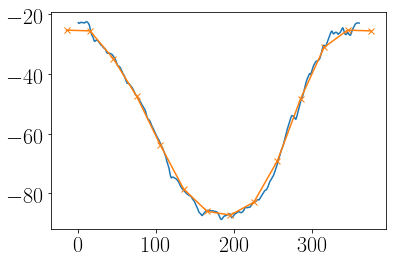

In [245]:
MLDa.shape
MLDm = np.zeros((12,))
for i in range(0,12):
    MLDm[i] = np.mean(MLDa[i*30:(i*30+30)])

MLDm = np.append(MLDm[-1], MLDm)
MLDm = np.append(MLDm, MLDm[1])
plt.plot(temp, MLDa)
plt.plot(np.linspace(-30,360,14)+15, MLDm, marker='x')
#plt.xlim(30,60)
#np.linspace(0,359,13)
#MLDm[-1]

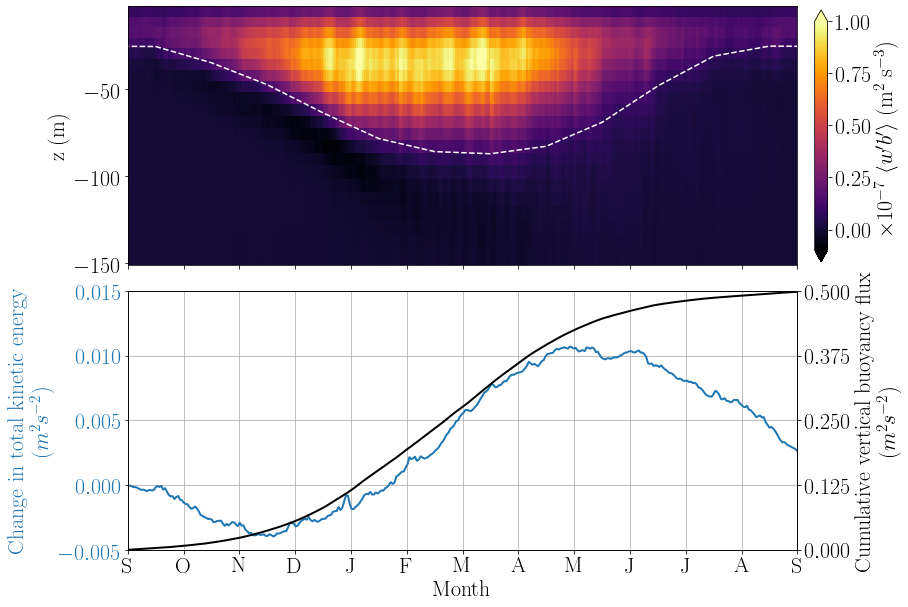

In [250]:

fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

cl = -1e-1
ch = 1e-0

ax0 = ax[0]
im = ax0.pcolormesh(temp[:]+240, np.mean(z_r[:,:,zm:], axis=(0,1)),np.transpose( wpbp[:,:]*1e7), vmin=cl, vmax=ch, cmap='inferno')
im.set_edgecolor('face')
cbar_ax = fig.add_axes([0.92, 0.525, 0.015, 0.35])
cb = fig.colorbar(im, cax=cbar_ax, extend='both')
cb.set_label(r'$\times 10^{-7}$ $\langle w^\prime b^\prime \rangle$ (m$^2$ s$^{-3}$)')
ax0.set_ylabel('z (m)')
#ax0.plot(240+temp, MLDa, color='w', linewidth=1.5)
ax0.plot(240+15+np.linspace(-30,360,14), MLDm, color='w', linewidth=1.5, linestyle='--')
ax1 = ax[1]
#ax1.plot(temp[mask], ekedi[mask]-ekedi[mask[0]], marker='x', label='$\Delta EKE_{k}$')
color='tab:blue'
#ax1.plot(xsa[masksorted], np.array(ekedisorted)[masksorted]-np.array(ekedisorted)[masksorted[0]], marker='d', label='$\Delta EKE$', color=color)
ax1.plot(temp[mask]+240, ekedi[mask]-ekedi[mask[0]],  label='$\Delta EKE_{k}$', color=color, linewidth=2)
ax1.set_xlim(240, 240+360)
ax1.set_ylim(-0.5e-2, 1.5e-2)
ax1.grid()
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks([240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600])
ax1.set_xticklabels(['S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S'])
#plt.plot(temp[mask], wpbpi[mask], marker='o')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(temp[mask]+240, wpbpti, color='k', label='$\int_0^t\; \langle w\' b\' \\rangle$ dt', linewidth=2)
ax2.set_ylim(0, 0.50e-0)
ax2.set_yticks([0, 0.125, 0.25, 0.375, 0.5])
ax1.set_xlabel('Month')
ax1.set_ylabel('Change in total kinetic energy\n ($m^2 s^{-2}$)', color=color)
ax2.set_ylabel('Cumulative vertical buoyancy flux\n ($m^2 s^{-2}$)')
#fig.legend(loc=9)
plt.subplots_adjust(hspace=0.1)
#plt.savefig('EnergyPlot.pdf', bbox_inches='tight')


In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(np.gradient(ekezi[mask])/np.gradient(temp[mask]*86400))
ax1.plot(np.gradient(ekedi[mask])/np.gradient(temp[mask]*86400))

#ax2 = ax1.twinx()
ax1.plot(wpbpi[mask], color='k', marker='o')

In [ ]:
kespec = spec2d_u.ispec + spec2d_v.ispec

k3 = np.array([1e-5,1e-4])
E3 = 1/k3**3/1e14
E2 = 1/k3**2; E2 = E2/E2[0]*E3[0]


fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
plt.loglog(spec2d_u.ki,kespec)
plt.loglog(spec2d_u.ki,kespec0)
plt.loglog(k3,E3,'k--')
plt.loglog(k3,E2,'k--')

plt.grid()
ax.set_xlabel(r"Wavenumber [m$^{-1}$]")
ax.set_ylabel(r"Spectral density")

In [ ]:
1/spec2d_u.ki[-1]/2

In [ ]:
msharkyearday.values[-1]

In [ ]:
np.mean(msharkgrid.pn**(-1)).values

In [ ]:
6/1500


In [ ]:
msharkyearday[-1].values

In [ ]:
np.diff(np.mean(z_r, axis=(0,1))[54:])

In [ ]:
np.max(msharkgrid.pn)-np.min(msharkgrid.pn)